# Ch 0.2.0: PareUNet2DConditionModel

## Part 0: Setup

In [67]:
# Install diffusers
!pip install transformers diffusers accelerate -U
!pip install parediffusers==0.1.2

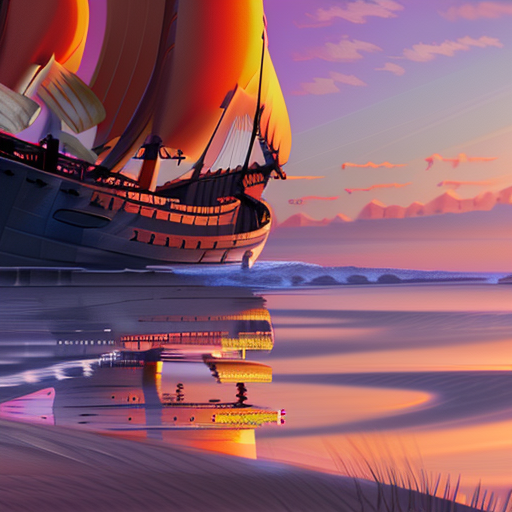

In [1]:
import torch
from parediffusers import PareDiffusionPipeline, PareDDIMScheduler

device = torch.device("cuda")
dtype = torch.float16
model_name = "stabilityai/stable-diffusion-2"
width = 512
height = 512
num_inference_steps = 50

pipe = PareDiffusionPipeline.from_pretrained(model_name)

prompt = "painting depicting the sea, sunrise, ship, artstation, 4k, concept art"
image = pipe(prompt)
image.show()

## Part 2: Get values of UNet

In [20]:
from diffusers import UNet2DConditionModel

unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet").to(
	device=device, dtype=dtype
)
unet

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0): Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): LoRACompatibleLinear(in_features=320, out_features=320, bias=True)
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): LoRACompatibleLinear(in_features=320, out_features=320, bias=False)
                (to_k): LoRACompatibleLinear(in_features=320, out_features=320, b

## Part 3: Check How Works from_pretrained

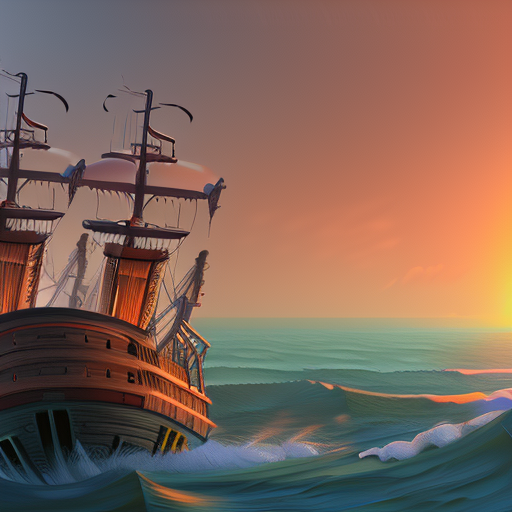

In [3]:
from diffusers.utils import (
	_get_model_file,
	_add_variant,
	WEIGHTS_NAME,
)

def from_pretrained(model_name, **kwargs):
	subfolder = kwargs.pop("subfolder", None)

	user_agent = {
		"diffusers": -1,
		"file_type": "model",
		"framework": "pytorch",
	}

	# load config
	config, unused_kwargs, commit_hash = UNet2DConditionModel.load_config(
		model_name,
		cache_dir=None,
		return_unused_kwargs=True,
		return_commit_hash=True,
		force_download=None,
		resume_download=None,
		proxies=None,
		local_files_only=None,
		token=None,
		revision=None,
		subfolder=subfolder,
		device_map=None,
		max_memory=None,
		offload_folder=None,
		offload_state_dict=None,
		user_agent=user_agent,
		**kwargs,
	)


	model_file = _get_model_file(
		model_name,
		weights_name=_add_variant(WEIGHTS_NAME, None),
		cache_dir=None,
		force_download=None,
		resume_download=None,
		proxies=None,
		local_files_only=None,
		token=None,
		revision=None,
		subfolder=subfolder,
		user_agent=user_agent,
		commit_hash=commit_hash,
	)

	model = UNet2DConditionModel.from_config(config, **unused_kwargs)
	state_dict = torch.load(model_file, map_location="cpu")
	model._convert_deprecated_attention_blocks(state_dict)

	model, _, _, _, _ = UNet2DConditionModel._load_pretrained_model(
		model,
		state_dict,
		model_file,
		model_name,
		ignore_mismatched_sizes=None,
	)
	model.register_to_config(_name_or_path=model_name)
	model.eval()
	return model

pare_unet = from_pretrained("stabilityai/stable-diffusion-2", subfolder="unet").to(
	device=device, dtype=dtype
)
pipe.unet = pare_unet

image = pipe(prompt)
image.show()


### Part 3.1: get_config

In [4]:
import json
from huggingface_hub import hf_hub_download

def get_config(model_name, subfolder=None):
	config_file = hf_hub_download(
		model_name,
		filename="config.json",
		subfolder=subfolder,
	)
	with open(config_file, "r", encoding="utf-8") as reader:
		text = reader.read()
	config = json.loads(text)
	return config

config = get_config(model_name, subfolder="unet")
config

{'_class_name': 'UNet2DConditionModel',
 '_diffusers_version': '0.8.0',
 '_name_or_path': 'hf-models/stable-diffusion-v2-768x768/unet',
 'act_fn': 'silu',
 'attention_head_dim': [5, 10, 20, 20],
 'block_out_channels': [320, 640, 1280, 1280],
 'center_input_sample': False,
 'cross_attention_dim': 1024,
 'down_block_types': ['CrossAttnDownBlock2D',
  'CrossAttnDownBlock2D',
  'CrossAttnDownBlock2D',
  'DownBlock2D'],
 'downsample_padding': 1,
 'dual_cross_attention': False,
 'flip_sin_to_cos': True,
 'freq_shift': 0,
 'in_channels': 4,
 'layers_per_block': 2,
 'mid_block_scale_factor': 1,
 'norm_eps': 1e-05,
 'norm_num_groups': 32,
 'out_channels': 4,
 'sample_size': 96,
 'up_block_types': ['UpBlock2D',
  'CrossAttnUpBlock2D',
  'CrossAttnUpBlock2D',
  'CrossAttnUpBlock2D'],
 'use_linear_projection': True}

### Part 3.2: Download model

In [5]:
model_file = hf_hub_download(
	model_name,
	filename="diffusion_pytorch_model.fp16.bin",
	subfolder="unet",
)
state_dict = torch.load(model_file, map_location="cpu")
state_dict

OrderedDict([('conv_in.weight',
              tensor([[[[-2.8732e-02,  1.9669e-02,  7.6233e-02],
                        [-1.8372e-02, -1.3074e-01,  1.0529e-01],
                        [-1.0185e-02, -1.6724e-02,  3.2440e-02]],
              
                       [[ 4.2786e-02, -6.3538e-02,  4.5586e-03],
                        [ 1.2634e-01, -1.0089e-01, -3.9551e-02],
                        [ 9.1324e-03, -8.7433e-03,  1.0521e-02]],
              
                       [[ 1.7776e-02, -1.6830e-02,  3.2532e-02],
                        [-2.0859e-02,  2.3590e-02,  3.9490e-02],
                        [-5.3329e-03, -5.8479e-03, -1.5900e-02]],
              
                       [[ 2.5375e-02, -3.3691e-02,  2.0416e-02],
                        [ 2.0905e-02, -7.9712e-02,  6.3843e-02],
                        [ 1.2159e-03, -2.4597e-02,  1.9287e-02]]],
              
              
                      [[[ 9.8877e-03, -7.3395e-03, -3.1174e-02],
                        [ 9.8953e-03,  2.05

In [8]:
model = UNet2DConditionModel.from_config(config)
model._convert_deprecated_attention_blocks(state_dict)
def load(module: torch.nn.Module, prefix: str = ""):
	args = (state_dict, prefix, {}, True, [], [], None)
	module._load_from_state_dict(*args)
	for name, child in module._modules.items():
		if child is not None:
			load(child, prefix + name + ".")

load(model)

model

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0): Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): LoRACompatibleLinear(in_features=320, out_features=320, bias=True)
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): LoRACompatibleLinear(in_features=320, out_features=320, bias=False)
                (to_k): LoRACompatibleLinear(in_features=320, out_features=320, b

### Part 3.3: class PareUNet2DConditionModel

In [9]:
import json
from typing import List
import torch
from huggingface_hub import hf_hub_download
from diffusers import UNet2DConditionModel

class PareUNet2DConditionModel(torch.nn.Module):
	def __init__(self):
		super().__init__()
	
	@classmethod
	def _get_config(cls, model_name, filename="config.json", subfolder=None):
		config_file = hf_hub_download(
			model_name,
			filename=filename,
			subfolder=subfolder,
		)
		with open(config_file, "r", encoding="utf-8") as reader:
			text = reader.read()
		config = json.loads(text)
		return config

	@classmethod
	def _load_state_dict_into_model(cls, model, state_dict) -> List[str]:
		state_dict = state_dict.copy()
		error_msgs = []

		def load(module: torch.nn.Module, prefix: str = ""):
			args = (state_dict, prefix, {}, True, [], [], error_msgs)
			module._load_from_state_dict(*args)
			for name, child in module._modules.items():
				if child is not None:
					load(child, prefix + name + ".")
		
		load(model)
		return model
	
	@classmethod
	def from_pretrained(cls, model_name, **kwargs):
		subfolder = kwargs.pop("subfolder", "unet")
		config_filename = kwargs.pop("config_filename", "config.json")
		model_filename = kwargs.pop("model_filename", "diffusion_pytorch_model.fp16.bin")
		
		config = cls._get_config(model_name, filename=config_filename, subfolder=subfolder)
		model_file = hf_hub_download(
			model_name,
			filename=model_filename,
			subfolder=subfolder,
		)
		state_dict = torch.load(model_file, map_location="cpu")
		
		model = UNet2DConditionModel.from_config(config)
		model._convert_deprecated_attention_blocks(state_dict)
		model = cls._load_state_dict_into_model(model, state_dict)
		model.register_to_config(_name_or_path=model_name)
		model.eval()
		return model


pare_unet = PareUNet2DConditionModel.from_pretrained("stabilityai/stable-diffusion-2",).to(
	device=device,
	dtype=dtype
)

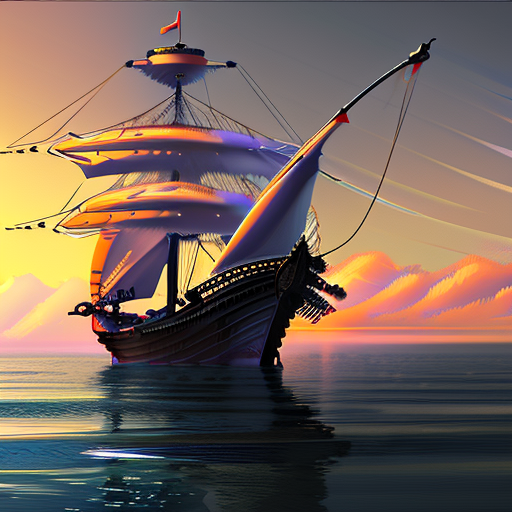

In [10]:
pipe.unet = pare_unet

image = pipe(prompt)
image.show()

## Part 4: Write a function to build model

### Part 4.1: Write The Overall Flow to Build Model

In [11]:
config = PareUNet2DConditionModel._get_config(model_name, subfolder="unet")
config

{'_class_name': 'UNet2DConditionModel',
 '_diffusers_version': '0.8.0',
 '_name_or_path': 'hf-models/stable-diffusion-v2-768x768/unet',
 'act_fn': 'silu',
 'attention_head_dim': [5, 10, 20, 20],
 'block_out_channels': [320, 640, 1280, 1280],
 'center_input_sample': False,
 'cross_attention_dim': 1024,
 'down_block_types': ['CrossAttnDownBlock2D',
  'CrossAttnDownBlock2D',
  'CrossAttnDownBlock2D',
  'DownBlock2D'],
 'downsample_padding': 1,
 'dual_cross_attention': False,
 'flip_sin_to_cos': True,
 'freq_shift': 0,
 'in_channels': 4,
 'layers_per_block': 2,
 'mid_block_scale_factor': 1,
 'norm_eps': 1e-05,
 'norm_num_groups': 32,
 'out_channels': 4,
 'sample_size': 96,
 'up_block_types': ['UpBlock2D',
  'CrossAttnUpBlock2D',
  'CrossAttnUpBlock2D',
  'CrossAttnUpBlock2D'],
 'use_linear_projection': True}

In [76]:
import json
import torch
import torch.nn as nn
from typing import List, Union
from huggingface_hub import hf_hub_download
from diffusers.models.embeddings import Timesteps, TimestepEmbedding
from diffusers.models.unet_2d_blocks import UNetMidBlock2DCrossAttn, get_down_block, get_up_block

DEFAULT_UNET_CONFIG = {
	"in_channels": 4,
	"out_channels": 4,
	"sample_size": 96,
	"center_input_sample": False,
	"flip_sin_to_cos": True,
	"freq_shift": 0,
	"down_block_types": [
		"CrossAttnDownBlock2D",
		"CrossAttnDownBlock2D",
		"CrossAttnDownBlock2D",
		"DownBlock2D",
	],
	"mid_block_type": "UNetMidBlock2DCrossAttn",
	"up_block_types": [
		"UpBlock2D",
		"CrossAttnUpBlock2D",
		"CrossAttnUpBlock2D",
		"CrossAttnUpBlock2D",
	],
	"only_cross_attention": False,
	"block_out_channels": [320, 640, 1280, 1280],
	"layers_per_block": 2,
	"downsample_padding": 1,
	"mid_block_scale_factor": 1,
	"dropout": 0.0,
	"act_fn": "silu",
	"norm_num_groups": 32,
	"norm_eps": 1e-5,
	"cross_attention_dim": 1024,
	"transformer_layers_per_block": 1,
	"reverse_transformer_layers_per_block": None,
	"encoder_hid_dim": None,
	"encoder_hid_dim_type": None,
	"attention_head_dim": [5, 10, 20, 20],
	"num_attention_heads": None,
	"dual_cross_attention": False,
	"use_linear_projection": True,
	"class_embed_type": None,
	"addition_embed_type": None,
	"addition_time_embed_dim": None,
	"num_class_embeds": None,
	"upcast_attention": False,
	"resnet_time_scale_shift": "default",
	"resnet_skip_time_act": False,
	"resnet_out_scale_factor": 1.0,
	"time_embedding_type": "positional",
	"time_embedding_dim": None,
	"time_embedding_act_fn": None,
	"timestep_post_act": None,
	"time_cond_proj_dim": None,
	"conv_in_kernel": 3,
	"conv_out_kernel": 3,
	"projection_class_embeddings_input_dim": None,
	"attention_type": "default",
	"class_embeddings_concat": False,
	"mid_block_only_cross_attention": None,
	"cross_attention_norm": None,
	"addition_embed_type_num_heads": 64,
	"_use_default_values": [
		"timestep_post_act",
		"addition_time_embed_dim",
		"conv_out_kernel",
		"encoder_hid_dim",
		"transformer_layers_per_block",
		"conv_in_kernel",
		"time_cond_proj_dim",
		"resnet_out_scale_factor",
		"only_cross_attention",
		"num_class_embeds",
		"upcast_attention",
		"mid_block_only_cross_attention",
		"time_embedding_type",
		"encoder_hid_dim_type",
		"num_attention_heads",
		"class_embed_type",
		"attention_type",
		"reverse_transformer_layers_per_block",
		"cross_attention_norm",
		"mid_block_type",
		"resnet_time_scale_shift",
		"addition_embed_type",
		"dropout",
		"class_embeddings_concat",
		"addition_embed_type_num_heads",
		"resnet_skip_time_act",
		"projection_class_embeddings_input_dim",
		"time_embedding_dim",
		"time_embedding_act_fn",
	],
	"_class_name": "UNet2DConditionModel",
	"_diffusers_version": "0.8.0",
	"_name_or_path": "stabilityai/stable-diffusion-2",	
}

ACTIVATION_FUNCTIONS = {
	"swish": nn.SiLU(),
	"silu": nn.SiLU(),
	"mish": nn.Mish(),
	"gelu": nn.GELU(),
	"relu": nn.ReLU(),
}

class DotDict(dict):
	"""dot.notation access to dictionary attributes"""
	__getattr__ = dict.get
	__setattr__ = dict.__setitem__
	__delattr__ = dict.__delitem__

def get_activation(act_fn: str) -> nn.Module:
	act_fn = act_fn.lower()
	if act_fn in ACTIVATION_FUNCTIONS:
		return ACTIVATION_FUNCTIONS[act_fn]
	else:
		raise ValueError(f"Unsupported activation function: {act_fn}")

class PareUNet2DConditionModel(nn.Module):
	def __init__(self, **kwargs):
		super().__init__()
		self.config = DotDict(DEFAULT_UNET_CONFIG)
		self.config.update(kwargs)
		self.config.only_cross_attention = [self.config.only_cross_attention] * len(self.config.down_block_types)
		self.config.num_attention_heads = self.config.num_attention_heads or self.config.attention_head_dim
		self._setup_model_parameters()

		self._build_input_layers()
		self._build_time_embedding()
		self._build_down_blocks()
		self._build_mid_block()
		self._build_up_blocks()
		self._build_output_layers()

	def _setup_model_parameters(self) -> None:
		if isinstance(self.config.num_attention_heads, int):
			self.config.num_attention_heads = (self.config.num_attention_heads,) * len(self.config.down_block_types)
		if isinstance(self.config.attention_head_dim, int):
			self.config.attention_head_dim = (self.config.attention_head_dim,) * len(self.config.down_block_types)
		if isinstance(self.config.cross_attention_dim, int):
			self.config.cross_attention_dim = (self.config.cross_attention_dim,) * len(self.config.down_block_types)
		if isinstance(self.config.layers_per_block, int):
			self.config.layers_per_block = [self.config.layers_per_block] * len(self.config.down_block_types)
		if isinstance(self.config.transformer_layers_per_block, int):
			self.config.transformer_layers_per_block = [self.config.transformer_layers_per_block] * len(self.config.down_block_types)

	def _build_input_layers(self) -> None:
		conv_in_padding = (self.config.conv_in_kernel - 1) // 2
		self.conv_in = nn.Conv2d(
			self.config.in_channels, self.config.block_out_channels[0], kernel_size=self.config.conv_in_kernel, padding=conv_in_padding
		)

	def _build_time_embedding(self) -> None:
		self.config.time_embed_dim = self.config.time_embedding_dim or self.config.block_out_channels[0] * 4
		self.time_proj = Timesteps(self.config.block_out_channels[0], self.config.flip_sin_to_cos, self.config.freq_shift)
		timestep_input_dim = self.config.block_out_channels[0]

		self.time_embedding = TimestepEmbedding(
			timestep_input_dim,
			self.config.time_embed_dim,
			act_fn=self.config.act_fn,
			post_act_fn=self.config.timestep_post_act,
			cond_proj_dim=self.config.time_cond_proj_dim,
		)

	def _build_down_blocks(self) -> None:
		self.down_blocks = nn.ModuleList([])
		output_channel = self.config.block_out_channels[0]
		for i, down_block_type in enumerate(self.config.down_block_types):
			input_channel = output_channel
			output_channel = self.config.block_out_channels[i]
			is_final_block = i == len(self.config.block_out_channels) - 1

			down_block = get_down_block(
				down_block_type,
				num_layers=self.config.layers_per_block[i],
				transformer_layers_per_block=self.config.transformer_layers_per_block[i],
				in_channels=input_channel,
				out_channels=output_channel,
				temb_channels=self.config.time_embed_dim,
				add_downsample=not is_final_block,
				resnet_eps=self.config.norm_eps,
				resnet_act_fn=self.config.act_fn,
				resnet_groups=self.config.norm_num_groups,
				cross_attention_dim=self.config.cross_attention_dim[i],
				num_attention_heads=self.config.num_attention_heads[i],
				downsample_padding=self.config.downsample_padding,
				use_linear_projection=self.config.use_linear_projection,
				only_cross_attention=self.config.only_cross_attention[i],
				upcast_attention=self.config.upcast_attention,
				attention_type=self.config.attention_type,
				resnet_skip_time_act=self.config.resnet_skip_time_act,
				resnet_out_scale_factor=self.config.resnet_out_scale_factor,
				cross_attention_norm=self.config.cross_attention_norm,
				attention_head_dim=self.config.attention_head_dim[i] if self.config.attention_head_dim[i] is not None else output_channel,
				dropout=self.config.dropout,
			)
			self.down_blocks.append(down_block)

	def _build_mid_block(self) -> None:
		# Supports only UNetMidBlock2DCrossAttn
		if self.config.mid_block_type != "UNetMidBlock2DCrossAttn":
			raise ValueError(f"mid_block_type {self.config.mid_block_type} not supported")

		self.mid_block = UNetMidBlock2DCrossAttn(
			transformer_layers_per_block=self.config.transformer_layers_per_block[-1],
			in_channels=self.config.block_out_channels[-1],
			temb_channels=self.config.time_embed_dim,
			dropout=self.config.dropout,
			resnet_eps=self.config.norm_eps,
			resnet_act_fn=self.config.act_fn,
			output_scale_factor=self.config.mid_block_scale_factor,
			cross_attention_dim=self.config.cross_attention_dim[-1],
			num_attention_heads=self.config.num_attention_heads[-1],
			resnet_groups=self.config.norm_num_groups,
			use_linear_projection=self.config.use_linear_projection,
			upcast_attention=self.config.upcast_attention,
			attention_type=self.config.attention_type,
		)

	def _build_up_blocks(self) -> None:
		self.up_blocks = nn.ModuleList([])
		self.num_upsamplers = 0

		reversed_block_out_channels = list(reversed(self.config.block_out_channels))
		reversed_num_attention_heads = list(reversed(self.config.num_attention_heads))
		reversed_layers_per_block = list(reversed(self.config.layers_per_block))
		reversed_cross_attention_dim = list(reversed(self.config.cross_attention_dim))
		reversed_transformer_layers_per_block = (
			list(reversed(self.config.transformer_layers_per_block))
			if self.config.reverse_transformer_layers_per_block is None
			else self.config.reverse_transformer_layers_per_block
		)
		self.config.only_cross_attention = list(reversed(self.config.only_cross_attention))

		output_channel = reversed_block_out_channels[0]
		for i, up_block_type in enumerate(self.config.up_block_types):
			is_final_block = i == len(self.config.block_out_channels) - 1

			prev_output_channel = output_channel
			output_channel = reversed_block_out_channels[i]
			input_channel = reversed_block_out_channels[min(i + 1, len(self.config.block_out_channels) - 1)]

			# add upsample block for all BUT final layer
			if not is_final_block:
				add_upsample = True
				self.num_upsamplers += 1
			else:
				add_upsample = False

			up_block = get_up_block(
				up_block_type,
				num_layers=reversed_layers_per_block[i] + 1,
				transformer_layers_per_block=reversed_transformer_layers_per_block[i],
				in_channels=input_channel,
				out_channels=output_channel,
				prev_output_channel=prev_output_channel,
				temb_channels=self.config.time_embed_dim,
				add_upsample=add_upsample,
				resnet_eps=self.config.norm_eps,
				resnet_act_fn=self.config.act_fn,
				resolution_idx=i,
				resnet_groups=self.config.norm_num_groups,
				cross_attention_dim=reversed_cross_attention_dim[i],
				num_attention_heads=reversed_num_attention_heads[i],
				use_linear_projection=self.config.use_linear_projection,
				only_cross_attention=self.config.only_cross_attention[i],
				upcast_attention=self.config.upcast_attention,
				attention_type=self.config.attention_type,
				resnet_skip_time_act=self.config.resnet_skip_time_act,
				resnet_out_scale_factor=self.config.resnet_out_scale_factor,
				cross_attention_norm=self.config.cross_attention_norm,
				attention_head_dim=self.config.attention_head_dim[i] if self.config.attention_head_dim[i] is not None else output_channel,
				dropout=self.config.dropout,
			)
			self.up_blocks.append(up_block)
			prev_output_channel = output_channel

	def _build_output_layers(self) -> None:
		if self.config.norm_num_groups is not None:
			self.conv_norm_out = nn.GroupNorm(
				num_channels=self.config.block_out_channels[0], num_groups=self.config.norm_num_groups, eps=self.config.norm_eps
			)
			self.conv_act = get_activation(self.config.act_fn)
		else:
			self.conv_norm_out = None
			self.conv_act = None

		conv_out_padding = (self.config.conv_out_kernel - 1) // 2
		self.conv_out = nn.Conv2d(
			self.config.block_out_channels[0], self.config.out_channels, kernel_size=self.config.conv_out_kernel, padding=conv_out_padding
		)

	@classmethod
	def _get_config(cls, model_name: str, filename: str = "config.json", subfolder: str = "unet") -> dict:
		config_file = hf_hub_download(
			model_name,
			filename=filename,
			subfolder=subfolder,
		)
		with open(config_file, "r", encoding="utf-8") as reader:
			text = reader.read()
		config = json.loads(text)
		return config

	@classmethod
	def _load_state_dict_into_model(cls, model: nn.Module, state_dict: dict) -> List[str]:
		state_dict = state_dict.copy()
		error_msgs = []

		def load(module: torch.nn.Module, prefix: str = ""):
			args = (state_dict, prefix, {}, True, [], [], error_msgs)
			module._load_from_state_dict(*args)
			for name, child in module._modules.items():
				if child is not None:
					load(child, prefix + name + ".")
		
		load(model)
		return model
	
	@classmethod
	def from_pretrained(cls, model_name: str, **kwargs) -> nn.Module:
		subfolder = kwargs.pop("subfolder", "unet")
		config_filename = kwargs.pop("config_filename", "config.json")
		model_filename = kwargs.pop("model_filename", "diffusion_pytorch_model.fp16.bin")
		
		config = cls._get_config(model_name, filename=config_filename, subfolder=subfolder)
		model_file = hf_hub_download(
			model_name,
			filename=model_filename,
			subfolder=subfolder,
		)
		state_dict = torch.load(model_file, map_location="cpu")
		
		model = PareUNet2DConditionModel(**config)
		model = cls._load_state_dict_into_model(model, state_dict)
		model.eval()
		return model

	def forward(
		self,
		sample: torch.FloatTensor,
		timestep: Union[torch.Tensor, float, int],
		encoder_hidden_states: torch.Tensor,
	) -> torch.FloatTensor:
		forward_upsample_size = False
		upsample_size = None

		# 1. time
		timesteps = timestep
		if len(timesteps.shape) == 0:
			timesteps = timesteps[None].to(sample.device)

		# broadcast to batch dimension in a way that's compatible with ONNX/Core ML
		timesteps = timesteps.expand(sample.shape[0])

		t_emb = self.time_proj(timesteps)
		t_emb = t_emb.to(dtype=sample.dtype)

		emb = self.time_embedding(t_emb, None)
		aug_emb = None

		emb = emb + aug_emb if aug_emb is not None else emb

		# 2. pre-process
		sample = self.conv_in(sample)

		# 3. down
		down_block_res_samples = (sample,)
		for downsample_block in self.down_blocks:
			if hasattr(downsample_block, "has_cross_attention") and downsample_block.has_cross_attention:
				# For t2i-adapter CrossAttnDownBlock2D
				additional_residuals = {}
				sample, res_samples = downsample_block(
					hidden_states=sample,
					temb=emb,
					encoder_hidden_states=encoder_hidden_states,
					**additional_residuals,
				)
			else:
				sample, res_samples = downsample_block(hidden_states=sample, temb=emb)
			down_block_res_samples += res_samples

		# 4. mid
		if self.mid_block is not None:
			if hasattr(self.mid_block, "has_cross_attention") and self.mid_block.has_cross_attention:
				sample = self.mid_block(
					sample,
					emb,
					encoder_hidden_states=encoder_hidden_states,
				)
			else:
				sample = self.mid_block(sample, emb)

		# 5. up
		for i, upsample_block in enumerate(self.up_blocks):
			is_final_block = i == len(self.up_blocks) - 1

			res_samples = down_block_res_samples[-len(upsample_block.resnets) :]
			down_block_res_samples = down_block_res_samples[: -len(upsample_block.resnets)]

			if not is_final_block and forward_upsample_size:
				upsample_size = down_block_res_samples[-1].shape[2:]

			if hasattr(upsample_block, "has_cross_attention") and upsample_block.has_cross_attention:
				sample = upsample_block(
					hidden_states=sample,
					temb=emb,
					res_hidden_states_tuple=res_samples,
					encoder_hidden_states=encoder_hidden_states,
					upsample_size=upsample_size,
				)
			else:
				sample = upsample_block(
					hidden_states=sample,
					temb=emb,
					res_hidden_states_tuple=res_samples,
					upsample_size=upsample_size,
				)

		# 6. post-process
		if self.conv_norm_out:
			sample = self.conv_norm_out(sample)
			sample = self.conv_act(sample)
		sample = self.conv_out(sample)
		return sample

pare_unet = PareUNet2DConditionModel.from_pretrained("stabilityai/stable-diffusion-2",).to(
	device=device,
	dtype=dtype
)

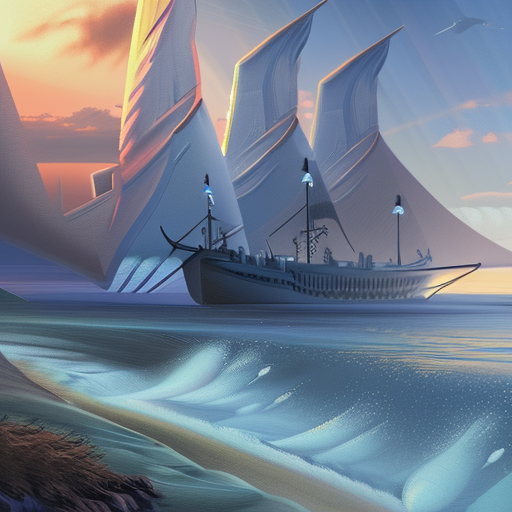

In [77]:
import torch
from PIL import Image
from torchvision.transforms import ToPILImage
from transformers import CLIPTokenizer, CLIPTextModel
from parediffusers.scheduler import PareDDIMScheduler
from diffusers import UNet2DConditionModel, AutoencoderKL

class PareDiffusionPipeline:
	def __init__(self, tokenizer, text_encoder, scheduler, unet, vae, device=torch.device("cuda"), dtype=torch.float16):
		"""
		Initialize the diffusion pipeline components.
		"""
		self.tokenizer = tokenizer
		self.text_encoder = text_encoder.to(device=device, dtype=dtype)
		self.scheduler = scheduler
		self.unet = unet.to(device=device, dtype=dtype)
		self.vae = vae.to(device=device, dtype=dtype)
		self.device = device
		self.dtype = dtype

	@classmethod
	def from_pretrained(cls, model_name, device=torch.device("cuda"), dtype=torch.float16):
		"""
		Load all necessary components from the pretrained model.

		Args:
			model_name (str): The name of the pretrained model.
			device (torch.device, optional): The device to use for the pipeline. Defaults to torch.device("cuda").
			dtype (torch.dtype, optional): The dtype to use for the pipeline. Defaults to torch.float16.
		
		Returns:
			PareDiffusionPipeline: The initialized pipeline.
		"""
		tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")
		text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder")
		scheduler = PareDDIMScheduler.from_config(model_name, subfolder="scheduler")
		unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet")
		vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae")
		return cls(tokenizer, text_encoder, scheduler, unet, vae, device, dtype)

	def encode_prompt(self, prompt: str):
		"""
		Encode the text prompt into embeddings using the text encoder.
		"""
		prompt_embeds = self.get_embes(prompt, self.tokenizer.model_max_length)
		negative_prompt_embeds = self.get_embes([''], prompt_embeds.shape[1])
		prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])
		return prompt_embeds

	def get_embes(self, prompt, max_length):
		"""
		Encode the text prompt into embeddings using the text encoder.
		"""
		text_inputs = self.tokenizer(prompt, padding="max_length", max_length=max_length, truncation=True, return_tensors="pt")
		text_input_ids = text_inputs.input_ids.to(self.device)
		prompt_embeds = self.text_encoder(text_input_ids)[0].to(dtype=self.dtype, device=self.device)
		return prompt_embeds

	def get_latent(self, width: int, height: int):
		"""
		Generate a random initial latent tensor to start the diffusion process.
		"""
		return torch.randn((4, width // 8, height // 8)).to(
			device=self.device, dtype=self.dtype
		)

	def retrieve_timesteps(self, num_inference_steps=None):
		"""
		Retrieve the timesteps for the diffusion process from the scheduler.
		"""
		self.scheduler.set_timesteps(num_inference_steps, device=self.device)
		timesteps = self.scheduler.timesteps
		return timesteps, num_inference_steps

	@torch.no_grad()
	def denoise(self, latents, prompt_embeds, num_inference_steps=50, guidance_scale=7.5):
		"""
		Iteratively denoise the latent space using the diffusion model to produce an image.
		"""
		timesteps, num_inference_steps = self.retrieve_timesteps(num_inference_steps)
	
		for t in timesteps:
			latent_model_input = torch.cat([latents] * 2)
			noise_residual = self.unet(latent_model_input, t, encoder_hidden_states=prompt_embeds)
			uncond_residual, text_cond_residual = noise_residual.chunk(2)
			guided_noise_residual = uncond_residual + guidance_scale * (text_cond_residual - uncond_residual)

			# Update latents by reversing the diffusion process for the current timestep
			latents = self.scheduler.step(guided_noise_residual, t, latents)[0]

		return latents
	
	def denormalize(self, image):
		"""
		Denormalize the image tensor to the range [0, 255].
		"""
		return (image / 2 + 0.5).clamp(0, 1)

	def tensor_to_image(self, tensor):
		"""
		Convert a tensor to a PIL Image.
		"""
		return ToPILImage()(tensor.detach().cpu())

	@torch.no_grad()
	def vae_decode(self, latents):
		"""
		Decode the latent tensors using the VAE to produce an image.
		"""
		image = self.vae.decode(latents / self.vae.config.scaling_factor)[0][0]
		image = self.denormalize(image)
		image = self.tensor_to_image(image)
		return image

	def __call__(self, prompt: str, height: int = 512, width: int = 512, num_inference_steps: int = 50, guidance_scale: int = 7.5):
		"""
		Generate an image from a text prompt using the entire pipeline.

		Args:
			prompt (str): The text prompt to generate an image from.
			height (int, optional): The height of the generated image. Defaults to 512.
			width (int, optional): The width of the generated image. Defaults to 512.
			num_inference_steps (int, optional): The number of diffusion steps to perform. Defaults to 50.
			guidance_scale (int, optional): The scale of the guidance. Defaults to 7.5.
		
		Returns:
			PIL.Image: The generated image.
		"""
		prompt_embeds = self.encode_prompt(prompt)
		latents = self.get_latent(width, height).unsqueeze(dim=0)
		latents = self.denoise(latents, prompt_embeds, num_inference_steps, guidance_scale)
		image = self.vae_decode(latents)
		return image


device = torch.device("cuda")
dtype = torch.float16
model_name = "stabilityai/stable-diffusion-2"

pipe = PareDiffusionPipeline.from_pretrained(model_name)

prompt = "painting depicting the sea, sunrise, ship, artstation, 4k, concept art"

pipe.unet = pare_unet
image = pipe(prompt)
image.show()

### Part 4.2 Write Embeddings

In [78]:
import math
from typing import Optional
import torch
import torch.nn as nn

def get_pare_timestep_embedding(
    timesteps: torch.Tensor,
    embedding_dim: int,
    flip_sin_to_cos: bool = False,
    downscale_freq_shift: float = 1,
    scale: float = 1,
    max_period: int = 10000,
):
    half_dim = embedding_dim // 2
    exponent = -math.log(max_period) * torch.arange(
        start=0, end=half_dim, dtype=torch.float32, device=timesteps.device
    )
    exponent = exponent / (half_dim - downscale_freq_shift)

    emb = torch.exp(exponent)
    emb = timesteps[:, None].float() * emb[None, :]

    # scale embeddings
    emb = scale * emb

    # concat sine and cosine embeddings
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)

    # flip sine and cosine embeddings
    if flip_sin_to_cos:
        emb = torch.cat([emb[:, half_dim:], emb[:, :half_dim]], dim=-1)

    # zero pad
    if embedding_dim % 2 == 1:
        emb = torch.nn.functional.pad(emb, (0, 1, 0, 0))
    return emb


class PareTimestepEmbedding(nn.Module):
    def __init__(
        self,
        in_channels: int,
        time_embed_dim: int,
        act_fn: str = "silu",
        out_dim: int = None,
        post_act_fn: Optional[str] = None,
        cond_proj_dim=None,
        sample_proj_bias=True,
    ):
        super().__init__()
        linear_cls = nn.Linear
        self.linear_1 = linear_cls(in_channels, time_embed_dim, sample_proj_bias)

        if cond_proj_dim is not None:
            self.cond_proj = nn.Linear(cond_proj_dim, in_channels, bias=False)
        else:
            self.cond_proj = None

        self.act = get_activation(act_fn)

        if out_dim is not None:
            time_embed_dim_out = out_dim
        else:
            time_embed_dim_out = time_embed_dim
        self.linear_2 = linear_cls(time_embed_dim, time_embed_dim_out, sample_proj_bias)

        if post_act_fn is None:
            self.post_act = None
        else:
            self.post_act = get_activation(post_act_fn)

    def forward(self, sample, condition=None):
        if condition is not None:
            sample = sample + self.cond_proj(condition)
        sample = self.linear_1(sample)

        if self.act is not None:
            sample = self.act(sample)

        sample = self.linear_2(sample)

        if self.post_act is not None:
            sample = self.post_act(sample)
        return sample
    
class PareTimesteps(nn.Module):
    def __init__(self, num_channels: int, flip_sin_to_cos: bool, downscale_freq_shift: float):
        super().__init__()
        self.num_channels = num_channels
        self.flip_sin_to_cos = flip_sin_to_cos
        self.downscale_freq_shift = downscale_freq_shift

    def forward(self, timesteps):
        t_emb = get_pare_timestep_embedding(
            timesteps,
            self.num_channels,
            flip_sin_to_cos=self.flip_sin_to_cos,
            downscale_freq_shift=self.downscale_freq_shift,
        )
        return t_emb

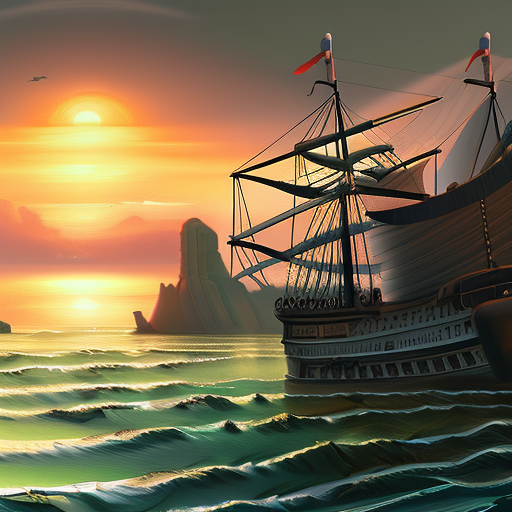

In [79]:
def _build_time_embedding(self) -> None:
		self.config.time_embed_dim = self.config.time_embedding_dim or self.config.block_out_channels[0] * 4
		self.time_proj = Timesteps(self.config.block_out_channels[0], self.config.flip_sin_to_cos, self.config.freq_shift)
		timestep_input_dim = self.config.block_out_channels[0]

		self.time_embedding = PareTimestepEmbedding(
			timestep_input_dim,
			self.config.time_embed_dim,
			act_fn=self.config.act_fn,
			post_act_fn=self.config.timestep_post_act,
			cond_proj_dim=self.config.time_cond_proj_dim,
		)
		self.config.time_embed_dim = self.config.time_embedding_dim or self.config.block_out_channels[0] * 4
		self.time_proj = PareTimesteps(self.config.block_out_channels[0], self.config.flip_sin_to_cos, self.config.freq_shift)
		timestep_input_dim = self.config.block_out_channels[0]

		self.time_embedding = PareTimestepEmbedding(
			timestep_input_dim,
			self.config.time_embed_dim,
			act_fn=self.config.act_fn,
			post_act_fn=self.config.timestep_post_act,
			cond_proj_dim=self.config.time_cond_proj_dim,
		)

PareUNet2DConditionModel._build_time_embedding = _build_time_embedding

pare_unet = PareUNet2DConditionModel.from_pretrained(model_name).to(
	device=device,
	dtype=dtype
)

pipe.unet = pare_unet
image = pipe(prompt)
image.show()

### Part 4.3 Write PareUNetMidBlock2DCrossAttn

In [80]:
from diffusers import UNet2DConditionModel

unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet").to(
	device=device, dtype=dtype
)

unet.config

FrozenDict([('sample_size', 96),
            ('in_channels', 4),
            ('out_channels', 4),
            ('center_input_sample', False),
            ('flip_sin_to_cos', True),
            ('freq_shift', 0),
            ('down_block_types',
             ['CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'DownBlock2D']),
            ('mid_block_type', 'UNetMidBlock2DCrossAttn'),
            ('up_block_types',
             ['UpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D']),
            ('only_cross_attention', False),
            ('block_out_channels', [320, 640, 1280, 1280]),
            ('layers_per_block', 2),
            ('downsample_padding', 1),
            ('mid_block_scale_factor', 1),
            ('dropout', 0.0),
            ('act_fn', 'silu'),
            ('norm_num_groups', 32),
            ('norm_eps', 1e-05),
            ('cross_attenti

In [81]:
from diffusers.models.upsampling import Upsample2D
from diffusers.models.downsampling import Downsample2D

class PareResnetBlock2D(nn.Module):
	def __init__(
		self,
		in_channels: int,
		out_channels: Optional[int] = None,
		temb_channels: int = 512,
		eps: float = 1e-6,
		groups: int = 32,
		groups_out: Optional[int] = None,
		dropout: float = 0.0,
		non_linearity: str = "swish",
		output_scale_factor: float = 1.0,
	):
		super().__init__()
		self.in_channels = in_channels
		out_channels = in_channels if out_channels is None else out_channels
		self.out_channels = out_channels
		self.output_scale_factor = output_scale_factor

		linear_cls = nn.Linear
		conv_cls =  nn.Conv2d

		if groups_out is None:
			groups_out = groups

		self.norm1 = torch.nn.GroupNorm(num_groups=groups, num_channels=in_channels, eps=eps, affine=True)

		self.conv1 = conv_cls(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

		if temb_channels is not None:
			self.time_emb_proj = linear_cls(temb_channels, out_channels)
		else:
			self.time_emb_proj = None

		self.norm2 = torch.nn.GroupNorm(num_groups=groups_out, num_channels=out_channels, eps=eps, affine=True)

		self.dropout = torch.nn.Dropout(dropout)
		self.conv2 = conv_cls(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

		self.nonlinearity = get_activation(non_linearity)

		self.upsample = self.downsample = None
		self.use_in_shortcut = self.in_channels != out_channels

		self.conv_shortcut = None
		if self.use_in_shortcut:
			self.conv_shortcut = conv_cls(
				in_channels,
				out_channels,
				kernel_size=1,
				stride=1,
				padding=0,
				bias=True,
			)

	def forward(
		self,
		input_tensor: torch.FloatTensor,
		temb: torch.FloatTensor,
		scale: float = 1.0,
	) -> torch.FloatTensor:
		hidden_states = input_tensor

		hidden_states = self.norm1(hidden_states)
		hidden_states = self.nonlinearity(hidden_states)

		if self.upsample is not None:
			# upsample_nearest_nhwc fails with large batch sizes. see https://github.com/huggingface/diffusers/issues/984
			if hidden_states.shape[0] >= 64:
				input_tensor = input_tensor.contiguous()
				hidden_states = hidden_states.contiguous()
			input_tensor = (
				self.upsample(input_tensor, scale=scale)
				if isinstance(self.upsample, Upsample2D)
				else self.upsample(input_tensor)
			)
			hidden_states = (
				self.upsample(hidden_states, scale=scale)
				if isinstance(self.upsample, Upsample2D)
				else self.upsample(hidden_states)
			)
		elif self.downsample is not None:
			input_tensor = (
				self.downsample(input_tensor, scale=scale)
				if isinstance(self.downsample, Downsample2D)
				else self.downsample(input_tensor)
			)
			hidden_states = (
				self.downsample(hidden_states, scale=scale)
				if isinstance(self.downsample, Downsample2D)
				else self.downsample(hidden_states)
			)

		hidden_states = self.conv1(hidden_states)

		temb = self.nonlinearity(temb)
		temb = (
			self.time_emb_proj(temb)[:, :, None, None]
		)

		hidden_states = hidden_states + temb
		hidden_states = self.norm2(hidden_states)

		hidden_states = self.nonlinearity(hidden_states)

		hidden_states = self.dropout(hidden_states)
		hidden_states = self.conv2(hidden_states)

		if self.conv_shortcut is not None:
			input_tensor = (
				self.conv_shortcut(input_tensor)
			)

		output_tensor = (input_tensor + hidden_states) / self.output_scale_factor

		return output_tensor

In [82]:
from typing import Optional, Dict, Any
from diffusers.models.resnet import (
	ResnetBlock2D,
)
from diffusers.models.transformer_2d import Transformer2DModel

class PareUNetMidBlock2DCrossAttn(nn.Module):
	def __init__(
		self,
		in_channels: int,
		temb_channels: int,
		dropout: float = 0.0,
		num_layers: int = 1,
		transformer_layers_per_block: int = 1,
		resnet_eps: float = 1e-6,
		resnet_act_fn: str = "swish",
		resnet_groups: int = 32,
		num_attention_heads: int = 1,
		output_scale_factor: float = 1.0,
		cross_attention_dim: int = 1280,
		use_linear_projection: bool = False,
		upcast_attention: bool = False,
		attention_type: str = "default",
	):
		super().__init__()

		self.has_cross_attention = True
		self.num_attention_heads = num_attention_heads
		resnet_groups = resnet_groups if resnet_groups is not None else min(in_channels // 4, 32)

		# support for variable transformer layers per block
		if isinstance(transformer_layers_per_block, int):
			transformer_layers_per_block = [transformer_layers_per_block] * num_layers

		# there is always at least one resnet
		resnets = [
			PareResnetBlock2D(
				in_channels=in_channels,
				out_channels=in_channels,
				temb_channels=temb_channels,
				eps=resnet_eps,
				groups=resnet_groups,
				dropout=dropout,
				non_linearity=resnet_act_fn,
				output_scale_factor=output_scale_factor,
			)
		]
		attentions = []

		for i in range(num_layers):
			attentions.append(
				Transformer2DModel(
					num_attention_heads,
					in_channels // num_attention_heads,
					in_channels=in_channels,
					num_layers=transformer_layers_per_block[i],
					cross_attention_dim=cross_attention_dim,
					norm_num_groups=resnet_groups,
					use_linear_projection=use_linear_projection,
					upcast_attention=upcast_attention,
					attention_type=attention_type,
				)
			)
			resnets.append(
				PareResnetBlock2D(
					in_channels=in_channels,
					out_channels=in_channels,
					temb_channels=temb_channels,
					eps=resnet_eps,
					groups=resnet_groups,
					dropout=dropout,
					non_linearity=resnet_act_fn,
					output_scale_factor=output_scale_factor,
				)
			)

		self.attentions = nn.ModuleList(attentions)
		self.resnets = nn.ModuleList(resnets)

		self.gradient_checkpointing = False

	def forward(
		self,
		hidden_states: torch.FloatTensor,
		temb: Optional[torch.FloatTensor] = None,
		encoder_hidden_states: Optional[torch.FloatTensor] = None,
		attention_mask: Optional[torch.FloatTensor] = None,
		cross_attention_kwargs: Optional[Dict[str, Any]] = None,
		encoder_attention_mask: Optional[torch.FloatTensor] = None,
	) -> torch.FloatTensor:
		hidden_states = self.resnets[0](hidden_states, temb)
		for attn, resnet in zip(self.attentions, self.resnets[1:]):
			hidden_states = attn(
				hidden_states,
				encoder_hidden_states=encoder_hidden_states,
				cross_attention_kwargs=cross_attention_kwargs,
				attention_mask=attention_mask,
				encoder_attention_mask=encoder_attention_mask,
				return_dict=False,
			)[0]
			hidden_states = resnet(hidden_states, temb)

		return hidden_states

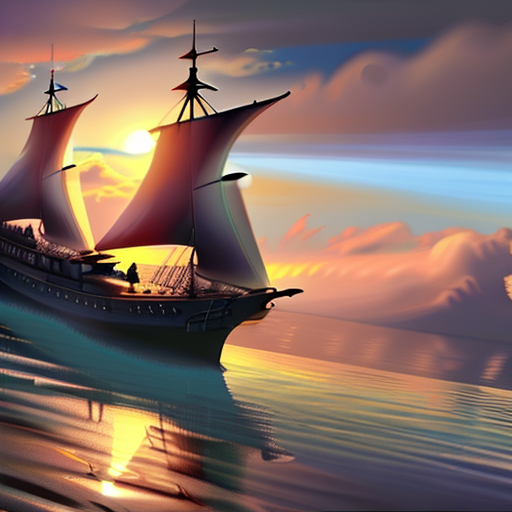

In [83]:
def _build_mid_block(self) -> None:
	# Supports only UNetMidBlock2DCrossAttn
	if self.config.mid_block_type != "UNetMidBlock2DCrossAttn":
		raise ValueError(f"mid_block_type {self.config.mid_block_type} not supported")

	self.mid_block = PareUNetMidBlock2DCrossAttn(
		transformer_layers_per_block=self.config.transformer_layers_per_block[-1],
		in_channels=self.config.block_out_channels[-1],
		temb_channels=self.config.time_embed_dim,
		dropout=self.config.dropout,
		resnet_eps=self.config.norm_eps,
		resnet_act_fn=self.config.act_fn,
		output_scale_factor=self.config.mid_block_scale_factor,
		cross_attention_dim=self.config.cross_attention_dim[-1],
		num_attention_heads=self.config.num_attention_heads[-1],
		resnet_groups=self.config.norm_num_groups,
		use_linear_projection=self.config.use_linear_projection,
		upcast_attention=self.config.upcast_attention,
		attention_type=self.config.attention_type,
	)

PareUNet2DConditionModel._build_mid_block = _build_mid_block

pare_unet = PareUNet2DConditionModel.from_pretrained(model_name).to(
	device=device,
	dtype=dtype
)

pipe.unet = pare_unet
image = pipe(prompt)
image.show()

### Part 4.4 Write PareTransformer2DModel

In [107]:
import torch.nn.functional as F
from diffusers.models.attention import BasicTransformerBlock

class PareTransformer2DModel(nn.Module):
	def __init__(
		self,
		num_attention_heads: int = 16,
		attention_head_dim: int = 88,
		in_channels: Optional[int] = None,
		out_channels: Optional[int] = None,
		num_layers: int = 1,
		dropout: float = 0.0,
		norm_num_groups: int = 32,
		cross_attention_dim: Optional[int] = None,
		attention_bias: bool = False,
		num_vector_embeds: Optional[int] = None,
		patch_size: Optional[int] = None,
		activation_fn: str = "geglu",
		use_linear_projection: bool = False,
		only_cross_attention: bool = False,
		double_self_attention: bool = False,
		upcast_attention: bool = False,
		norm_type: str = "layer_norm",
		norm_elementwise_affine: bool = True,
		norm_eps: float = 1e-5,
		attention_type: str = "default",
	):
		super().__init__()
		self.use_linear_projection = use_linear_projection
		self.num_attention_heads = num_attention_heads
		self.attention_head_dim = attention_head_dim
		inner_dim = num_attention_heads * attention_head_dim

		conv_cls = nn.Conv2d
		linear_cls = nn.Linear

		# 1. Transformer2DModel can process both standard continuous images of shape `(batch_size, num_channels, width, height)` as well as quantized image embeddings of shape `(batch_size, num_image_vectors)`
		# Define whether input is continuous or discrete depending on configuration
		self.is_input_continuous = (in_channels is not None) and (patch_size is None)
		self.is_input_vectorized = num_vector_embeds is not None
		self.is_input_patches = in_channels is not None and patch_size is not None

		# 2. Define input layers
		self.in_channels = in_channels

		self.norm = torch.nn.GroupNorm(num_groups=norm_num_groups, num_channels=in_channels, eps=1e-6, affine=True)
		if use_linear_projection:
			self.proj_in = linear_cls(in_channels, inner_dim)
		else:
			self.proj_in = conv_cls(in_channels, inner_dim, kernel_size=1, stride=1, padding=0)

		# 3. Define transformers blocks
		self.transformer_blocks = nn.ModuleList(
			[
				BasicTransformerBlock(
					inner_dim,
					num_attention_heads,
					attention_head_dim,
					dropout=dropout,
					cross_attention_dim=cross_attention_dim,
					activation_fn=activation_fn,
					attention_bias=attention_bias,
					only_cross_attention=only_cross_attention,
					double_self_attention=double_self_attention,
					upcast_attention=upcast_attention,
					norm_type=norm_type,
					norm_elementwise_affine=norm_elementwise_affine,
					norm_eps=norm_eps,
					attention_type=attention_type,
				)
				for d in range(num_layers)
			]
		)

		# 4. Define output layers
		self.out_channels = in_channels if out_channels is None else out_channels
		if self.is_input_continuous:
			# TODO: should use out_channels for continuous projections
			if use_linear_projection:
				self.proj_out = linear_cls(inner_dim, in_channels)
			else:
				self.proj_out = conv_cls(inner_dim, in_channels, kernel_size=1, stride=1, padding=0)
		elif self.is_input_vectorized:
			self.norm_out = nn.LayerNorm(inner_dim)
			self.out = nn.Linear(inner_dim, self.num_vector_embeds - 1)
		elif self.is_input_patches and norm_type != "ada_norm_single":
			self.norm_out = nn.LayerNorm(inner_dim, elementwise_affine=False, eps=1e-6)
			self.proj_out_1 = nn.Linear(inner_dim, 2 * inner_dim)
			self.proj_out_2 = nn.Linear(inner_dim, patch_size * patch_size * self.out_channels)
		elif self.is_input_patches and norm_type == "ada_norm_single":
			self.norm_out = nn.LayerNorm(inner_dim, elementwise_affine=False, eps=1e-6)
			self.scale_shift_table = nn.Parameter(torch.randn(2, inner_dim) / inner_dim**0.5)
			self.proj_out = nn.Linear(inner_dim, patch_size * patch_size * self.out_channels)

		# 5. PixArt-Alpha blocks.
		self.adaln_single = None
		self.use_additional_conditions = False

		self.caption_projection = None
		self.gradient_checkpointing = False

	def _set_gradient_checkpointing(self, module, value=False):
		if hasattr(module, "gradient_checkpointing"):
			module.gradient_checkpointing = value

	def forward(
		self,
		hidden_states: torch.Tensor,
		encoder_hidden_states: Optional[torch.Tensor] = None,
		timestep: Optional[torch.LongTensor] = None,
		added_cond_kwargs: Dict[str, torch.Tensor] = None,
		class_labels: Optional[torch.LongTensor] = None,
		cross_attention_kwargs: Dict[str, Any] = None,
		attention_mask: Optional[torch.Tensor] = None,
		encoder_attention_mask: Optional[torch.Tensor] = None,
		return_dict: bool = True,
	):
		if attention_mask is not None and attention_mask.ndim == 2:
			attention_mask = (1 - attention_mask.to(hidden_states.dtype)) * -10000.0
			attention_mask = attention_mask.unsqueeze(1)

		# convert encoder_attention_mask to a bias the same way we do for attention_mask
		if encoder_attention_mask is not None and encoder_attention_mask.ndim == 2:
			encoder_attention_mask = (1 - encoder_attention_mask.to(hidden_states.dtype)) * -10000.0
			encoder_attention_mask = encoder_attention_mask.unsqueeze(1)
		
		# 1. Input
		if self.is_input_continuous:
			batch, _, height, width = hidden_states.shape
			residual = hidden_states

			hidden_states = self.norm(hidden_states)
			if not self.use_linear_projection:
				hidden_states = (
					self.proj_in(hidden_states)
				)
				inner_dim = hidden_states.shape[1]
				hidden_states = hidden_states.permute(0, 2, 3, 1).reshape(batch, height * width, inner_dim)
			else:
				inner_dim = hidden_states.shape[1]
				hidden_states = hidden_states.permute(0, 2, 3, 1).reshape(batch, height * width, inner_dim)
				hidden_states = (
					self.proj_in(hidden_states)
				)

		elif self.is_input_vectorized:
			hidden_states = self.latent_image_embedding(hidden_states)
		elif self.is_input_patches:
			height, width = hidden_states.shape[-2] // self.patch_size, hidden_states.shape[-1] // self.patch_size
			hidden_states = self.pos_embed(hidden_states)

			if self.adaln_single is not None:
				if self.use_additional_conditions and added_cond_kwargs is None:
					raise ValueError(
						"`added_cond_kwargs` cannot be None when using additional conditions for `adaln_single`."
					)
				batch_size = hidden_states.shape[0]
				timestep, embedded_timestep = self.adaln_single(
					timestep, added_cond_kwargs, batch_size=batch_size, hidden_dtype=hidden_states.dtype
				)

		# 2. Blocks
		if self.caption_projection is not None:
			batch_size = hidden_states.shape[0]
			encoder_hidden_states = self.caption_projection(encoder_hidden_states)
			encoder_hidden_states = encoder_hidden_states.view(batch_size, -1, hidden_states.shape[-1])

		for block in self.transformer_blocks:
			if self.training and self.gradient_checkpointing:

				def create_custom_forward(module, return_dict=None):
					def custom_forward(*inputs):
						if return_dict is not None:
							return module(*inputs, return_dict=return_dict)
						else:
							return module(*inputs)

					return custom_forward

				ckpt_kwargs: Dict[str, Any] = {"use_reentrant": False}
				hidden_states = torch.utils.checkpoint.checkpoint(
					create_custom_forward(block),
					hidden_states,
					attention_mask,
					encoder_hidden_states,
					encoder_attention_mask,
					timestep,
					cross_attention_kwargs,
					class_labels,
					**ckpt_kwargs,
				)
			else:
				hidden_states = block(
					hidden_states,
					attention_mask=attention_mask,
					encoder_hidden_states=encoder_hidden_states,
					encoder_attention_mask=encoder_attention_mask,
					timestep=timestep,
					cross_attention_kwargs=cross_attention_kwargs,
					class_labels=class_labels,
				)

		# 3. Output
		if self.is_input_continuous:
			if not self.use_linear_projection:
				hidden_states = hidden_states.reshape(batch, height, width, inner_dim).permute(0, 3, 1, 2).contiguous()
				hidden_states = (
					self.proj_out(hidden_states)
				)
			else:
				hidden_states = (
					self.proj_out(hidden_states)
				)
				hidden_states = hidden_states.reshape(batch, height, width, inner_dim).permute(0, 3, 1, 2).contiguous()

			output = hidden_states + residual
		elif self.is_input_vectorized:
			hidden_states = self.norm_out(hidden_states)
			logits = self.out(hidden_states)
			# (batch, self.num_vector_embeds - 1, self.num_latent_pixels)
			logits = logits.permute(0, 2, 1)

			# log(p(x_0))
			output = F.log_softmax(logits.double(), dim=1).float()

		if self.is_input_patches:
			if self.config.norm_type != "ada_norm_single":
				conditioning = self.transformer_blocks[0].norm1.emb(
					timestep, class_labels, hidden_dtype=hidden_states.dtype
				)
				shift, scale = self.proj_out_1(F.silu(conditioning)).chunk(2, dim=1)
				hidden_states = self.norm_out(hidden_states) * (1 + scale[:, None]) + shift[:, None]
				hidden_states = self.proj_out_2(hidden_states)
			elif self.config.norm_type == "ada_norm_single":
				shift, scale = (self.scale_shift_table[None] + embedded_timestep[:, None]).chunk(2, dim=1)
				hidden_states = self.norm_out(hidden_states)
				# Modulation
				hidden_states = hidden_states * (1 + scale) + shift
				hidden_states = self.proj_out(hidden_states)
				hidden_states = hidden_states.squeeze(1)

			# unpatchify
			if self.adaln_single is None:
				height = width = int(hidden_states.shape[1] ** 0.5)
			hidden_states = hidden_states.reshape(
				shape=(-1, height, width, self.patch_size, self.patch_size, self.out_channels)
			)
			hidden_states = torch.einsum("nhwpqc->nchpwq", hidden_states)
			output = hidden_states.reshape(
				shape=(-1, self.out_channels, height * self.patch_size, width * self.patch_size)
			)

		if not return_dict:
			return (output,)

		return output

In [104]:
from typing import Optional, Dict, Any

class PareUNetMidBlock2DCrossAttn(nn.Module):
	def __init__(
		self,
		in_channels: int,
		temb_channels: int,
		dropout: float = 0.0,
		num_layers: int = 1,
		transformer_layers_per_block: int = 1,
		resnet_eps: float = 1e-6,
		resnet_act_fn: str = "swish",
		resnet_groups: int = 32,
		num_attention_heads: int = 1,
		output_scale_factor: float = 1.0,
		cross_attention_dim: int = 1280,
		use_linear_projection: bool = False,
		upcast_attention: bool = False,
		attention_type: str = "default",
	):
		super().__init__()

		self.has_cross_attention = True
		self.num_attention_heads = num_attention_heads
		resnet_groups = resnet_groups if resnet_groups is not None else min(in_channels // 4, 32)

		# support for variable transformer layers per block
		if isinstance(transformer_layers_per_block, int):
			transformer_layers_per_block = [transformer_layers_per_block] * num_layers

		# there is always at least one resnet
		resnets = [
			PareResnetBlock2D(
				in_channels=in_channels,
				out_channels=in_channels,
				temb_channels=temb_channels,
				eps=resnet_eps,
				groups=resnet_groups,
				dropout=dropout,
				non_linearity=resnet_act_fn,
				output_scale_factor=output_scale_factor,
			)
		]
		attentions = []

		for i in range(num_layers):
			attentions.append(
				PareTransformer2DModel(
					num_attention_heads,
					in_channels // num_attention_heads,
					in_channels=in_channels,
					num_layers=transformer_layers_per_block[i],
					cross_attention_dim=cross_attention_dim,
					norm_num_groups=resnet_groups,
					use_linear_projection=use_linear_projection,
					upcast_attention=upcast_attention,
					attention_type=attention_type,
				)
			)
			resnets.append(
				PareResnetBlock2D(
					in_channels=in_channels,
					out_channels=in_channels,
					temb_channels=temb_channels,
					eps=resnet_eps,
					groups=resnet_groups,
					dropout=dropout,
					non_linearity=resnet_act_fn,
					output_scale_factor=output_scale_factor,
				)
			)

		self.attentions = nn.ModuleList(attentions)
		self.resnets = nn.ModuleList(resnets)

		self.gradient_checkpointing = False

	def forward(
		self,
		hidden_states: torch.FloatTensor,
		temb: Optional[torch.FloatTensor] = None,
		encoder_hidden_states: Optional[torch.FloatTensor] = None,
		attention_mask: Optional[torch.FloatTensor] = None,
		cross_attention_kwargs: Optional[Dict[str, Any]] = None,
		encoder_attention_mask: Optional[torch.FloatTensor] = None,
	) -> torch.FloatTensor:
		hidden_states = self.resnets[0](hidden_states, temb)
		for attn, resnet in zip(self.attentions, self.resnets[1:]):
			hidden_states = attn(
				hidden_states,
				encoder_hidden_states=encoder_hidden_states,
				cross_attention_kwargs=cross_attention_kwargs,
				attention_mask=attention_mask,
				encoder_attention_mask=encoder_attention_mask,
				return_dict=False,
			)[0]
			hidden_states = resnet(hidden_states, temb)

		return hidden_states


cross_attention_dim 1024
activation_fn geglu
attention_bias False
only_cross_attention False
double_self_attention False
upcast_attention False
norm_type layer_norm
norm_elementwise_affine True
norm_eps 1e-05
attention_type default


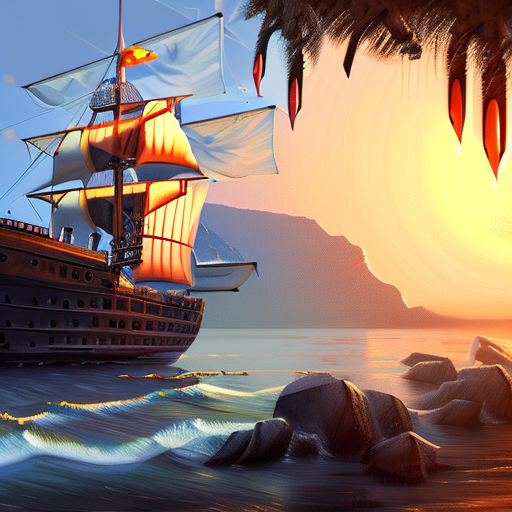

In [105]:
pare_unet = PareUNet2DConditionModel.from_pretrained(model_name).to(
	device=device,
	dtype=dtype
)

pipe.unet = pare_unet
image = pipe(prompt)
image.show()

In [108]:
class PareBasicTransformerBlock(nn.Module):
    def __init__(
        self,
        dim: int,
        num_attention_heads: int,
        attention_head_dim: int,
        dropout=0.0,
        cross_attention_dim: Optional[int] = None,
        activation_fn: str = "geglu",
        num_embeds_ada_norm: Optional[int] = None,
        attention_bias: bool = False,
        only_cross_attention: bool = False,
        double_self_attention: bool = False,
        upcast_attention: bool = False,
        norm_elementwise_affine: bool = True,
        norm_type: str = "layer_norm",
        norm_eps: float = 1e-5,
        final_dropout: bool = False,
        attention_type: str = "default",
        ada_norm_continous_conditioning_embedding_dim: Optional[int] = None,
        ada_norm_bias: Optional[int] = None,
        ff_inner_dim: Optional[int] = None,
        ff_bias: bool = True,
        attention_out_bias: bool = True,
    ):
        super().__init__()
        self.only_cross_attention = only_cross_attention

        self.norm1 = nn.LayerNorm(dim, elementwise_affine=norm_elementwise_affine, eps=norm_eps)

        self.attn1 = Attention(
            query_dim=dim,
            heads=num_attention_heads,
            dim_head=attention_head_dim,
            dropout=dropout,
            bias=attention_bias,
            cross_attention_dim=cross_attention_dim if only_cross_attention else None,
            upcast_attention=upcast_attention,
            out_bias=attention_out_bias,
        )

        # 2. Cross-Attn
        if cross_attention_dim is not None or double_self_attention:
            self.norm2 = nn.LayerNorm(dim, norm_eps, norm_elementwise_affine)

            self.attn2 = Attention(
                query_dim=dim,
                cross_attention_dim=cross_attention_dim if not double_self_attention else None,
                heads=num_attention_heads,
                dim_head=attention_head_dim,
                dropout=dropout,
                bias=attention_bias,
                upcast_attention=upcast_attention,
                out_bias=attention_out_bias,
            )  # is self-attn if encoder_hidden_states is none
        else:
            self.norm2 = None
            self.attn2 = None

        self.ff = FeedForward(
            dim,
            dropout=dropout,
            activation_fn=activation_fn,
            final_dropout=final_dropout,
            inner_dim=ff_inner_dim,
            bias=ff_bias,
        )

        # let chunk size default to None
        self._chunk_size = None
        self._chunk_dim = 0

    def set_chunk_feed_forward(self, chunk_size: Optional[int], dim: int = 0):
        # Sets chunk feed-forward
        self._chunk_size = chunk_size
        self._chunk_dim = dim

    def forward(
        self,
        hidden_states: torch.FloatTensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        cross_attention_kwargs: Dict[str, Any] = None,
        added_cond_kwargs: Optional[Dict[str, torch.Tensor]] = None,
    ) -> torch.FloatTensor:
        # Notice that normalization is always applied before the real computation in the following blocks.
        # 0. Self-Attention
        batch_size = hidden_states.shape[0]

        norm_hidden_states = self.norm1(hidden_states)

        if self.pos_embed is not None:
            norm_hidden_states = self.pos_embed(norm_hidden_states)

        # 1. Retrieve lora scale.
        lora_scale = cross_attention_kwargs.get("scale", 1.0) if cross_attention_kwargs is not None else 1.0

        # 2. Prepare GLIGEN inputs
        cross_attention_kwargs = cross_attention_kwargs.copy() if cross_attention_kwargs is not None else {}
        gligen_kwargs = cross_attention_kwargs.pop("gligen", None)

        attn_output = self.attn1(
            norm_hidden_states,
            encoder_hidden_states=encoder_hidden_states if self.only_cross_attention else None,
            attention_mask=attention_mask,
            **cross_attention_kwargs,
        )
        if self.use_ada_layer_norm_zero:
            attn_output = gate_msa.unsqueeze(1) * attn_output
        elif self.use_ada_layer_norm_single:
            attn_output = gate_msa * attn_output

        hidden_states = attn_output + hidden_states
        if hidden_states.ndim == 4:
            hidden_states = hidden_states.squeeze(1)

        # 2.5 GLIGEN Control
        if gligen_kwargs is not None:
            hidden_states = self.fuser(hidden_states, gligen_kwargs["objs"])

        # 3. Cross-Attention
        if self.attn2 is not None:
            norm_hidden_states = self.norm2(hidden_states)

            if self.pos_embed is not None and self.use_ada_layer_norm_single is False:
                norm_hidden_states = self.pos_embed(norm_hidden_states)

            attn_output = self.attn2(
                norm_hidden_states,
                encoder_hidden_states=encoder_hidden_states,
                attention_mask=encoder_attention_mask,
                **cross_attention_kwargs,
            )
            hidden_states = attn_output + hidden_states

        # 4. Feed-forward
        if self.use_ada_layer_norm_continuous:
            norm_hidden_states = self.norm3(hidden_states, added_cond_kwargs["pooled_text_emb"])
        elif not self.use_ada_layer_norm_single:
            norm_hidden_states = self.norm3(hidden_states)

        if self.use_ada_layer_norm_zero:
            norm_hidden_states = norm_hidden_states * (1 + scale_mlp[:, None]) + shift_mlp[:, None]

        if self.use_ada_layer_norm_single:
            norm_hidden_states = self.norm2(hidden_states)
            norm_hidden_states = norm_hidden_states * (1 + scale_mlp) + shift_mlp

        if self._chunk_size is not None:
            # "feed_forward_chunk_size" can be used to save memory
            ff_output = _chunked_feed_forward(
                self.ff, norm_hidden_states, self._chunk_dim, self._chunk_size, lora_scale=lora_scale
            )
        else:
            ff_output = self.ff(norm_hidden_states, scale=lora_scale)

        if self.use_ada_layer_norm_zero:
            ff_output = gate_mlp.unsqueeze(1) * ff_output
        elif self.use_ada_layer_norm_single:
            ff_output = gate_mlp * ff_output

        hidden_states = ff_output + hidden_states
        if hidden_states.ndim == 4:
            hidden_states = hidden_states.squeeze(1)

        return hidden_states

In [110]:
import torch.nn.functional as F
from diffusers.models.attention import BasicTransformerBlock

class PareTransformer2DModel(nn.Module):
	def __init__(
		self,
		num_attention_heads: int = 16,
		attention_head_dim: int = 88,
		in_channels: Optional[int] = None,
		out_channels: Optional[int] = None,
		num_layers: int = 1,
		dropout: float = 0.0,
		norm_num_groups: int = 32,
		cross_attention_dim: Optional[int] = None,
		attention_bias: bool = False,
		num_vector_embeds: Optional[int] = None,
		patch_size: Optional[int] = None,
		activation_fn: str = "geglu",
		use_linear_projection: bool = False,
		only_cross_attention: bool = False,
		double_self_attention: bool = False,
		upcast_attention: bool = False,
		norm_type: str = "layer_norm",
		norm_elementwise_affine: bool = True,
		norm_eps: float = 1e-5,
		attention_type: str = "default",
	):
		super().__init__()
		self.use_linear_projection = use_linear_projection
		self.num_attention_heads = num_attention_heads
		self.attention_head_dim = attention_head_dim
		inner_dim = num_attention_heads * attention_head_dim

		conv_cls = nn.Conv2d
		linear_cls = nn.Linear

		# 1. Transformer2DModel can process both standard continuous images of shape `(batch_size, num_channels, width, height)` as well as quantized image embeddings of shape `(batch_size, num_image_vectors)`
		# Define whether input is continuous or discrete depending on configuration
		self.is_input_continuous = (in_channels is not None) and (patch_size is None)
		self.is_input_vectorized = num_vector_embeds is not None
		self.is_input_patches = in_channels is not None and patch_size is not None

		# 2. Define input layers
		self.in_channels = in_channels

		self.norm = torch.nn.GroupNorm(num_groups=norm_num_groups, num_channels=in_channels, eps=1e-6, affine=True)
		if use_linear_projection:
			self.proj_in = linear_cls(in_channels, inner_dim)
		else:
			self.proj_in = conv_cls(in_channels, inner_dim, kernel_size=1, stride=1, padding=0)

		# 3. Define transformers blocks
		self.transformer_blocks = nn.ModuleList(
			[
				PareBasicTransformerBlock(
					inner_dim,
					num_attention_heads,
					attention_head_dim,
					dropout=dropout,
					cross_attention_dim=cross_attention_dim,
					activation_fn=activation_fn,
					attention_bias=attention_bias,
					only_cross_attention=only_cross_attention,
					double_self_attention=double_self_attention,
					upcast_attention=upcast_attention,
					norm_type=norm_type,
					norm_elementwise_affine=norm_elementwise_affine,
					norm_eps=norm_eps,
					attention_type=attention_type,
				)
				for d in range(num_layers)
			]
		)

		# 4. Define output layers
		self.out_channels = in_channels if out_channels is None else out_channels
		if self.is_input_continuous:
			# TODO: should use out_channels for continuous projections
			if use_linear_projection:
				self.proj_out = linear_cls(inner_dim, in_channels)
			else:
				self.proj_out = conv_cls(inner_dim, in_channels, kernel_size=1, stride=1, padding=0)
		elif self.is_input_vectorized:
			self.norm_out = nn.LayerNorm(inner_dim)
			self.out = nn.Linear(inner_dim, self.num_vector_embeds - 1)
		elif self.is_input_patches and norm_type != "ada_norm_single":
			self.norm_out = nn.LayerNorm(inner_dim, elementwise_affine=False, eps=1e-6)
			self.proj_out_1 = nn.Linear(inner_dim, 2 * inner_dim)
			self.proj_out_2 = nn.Linear(inner_dim, patch_size * patch_size * self.out_channels)
		elif self.is_input_patches and norm_type == "ada_norm_single":
			self.norm_out = nn.LayerNorm(inner_dim, elementwise_affine=False, eps=1e-6)
			self.scale_shift_table = nn.Parameter(torch.randn(2, inner_dim) / inner_dim**0.5)
			self.proj_out = nn.Linear(inner_dim, patch_size * patch_size * self.out_channels)

		# 5. PixArt-Alpha blocks.
		self.adaln_single = None
		self.use_additional_conditions = False

		self.caption_projection = None
		self.gradient_checkpointing = False

	def _set_gradient_checkpointing(self, module, value=False):
		if hasattr(module, "gradient_checkpointing"):
			module.gradient_checkpointing = value

	def forward(
		self,
		hidden_states: torch.Tensor,
		encoder_hidden_states: Optional[torch.Tensor] = None,
		timestep: Optional[torch.LongTensor] = None,
		added_cond_kwargs: Dict[str, torch.Tensor] = None,
		class_labels: Optional[torch.LongTensor] = None,
		cross_attention_kwargs: Dict[str, Any] = None,
		attention_mask: Optional[torch.Tensor] = None,
		encoder_attention_mask: Optional[torch.Tensor] = None,
		return_dict: bool = True,
	):
		if attention_mask is not None and attention_mask.ndim == 2:
			attention_mask = (1 - attention_mask.to(hidden_states.dtype)) * -10000.0
			attention_mask = attention_mask.unsqueeze(1)

		# convert encoder_attention_mask to a bias the same way we do for attention_mask
		if encoder_attention_mask is not None and encoder_attention_mask.ndim == 2:
			encoder_attention_mask = (1 - encoder_attention_mask.to(hidden_states.dtype)) * -10000.0
			encoder_attention_mask = encoder_attention_mask.unsqueeze(1)
		
		# 1. Input
		if self.is_input_continuous:
			batch, _, height, width = hidden_states.shape
			residual = hidden_states

			hidden_states = self.norm(hidden_states)
			if not self.use_linear_projection:
				hidden_states = (
					self.proj_in(hidden_states)
				)
				inner_dim = hidden_states.shape[1]
				hidden_states = hidden_states.permute(0, 2, 3, 1).reshape(batch, height * width, inner_dim)
			else:
				inner_dim = hidden_states.shape[1]
				hidden_states = hidden_states.permute(0, 2, 3, 1).reshape(batch, height * width, inner_dim)
				hidden_states = (
					self.proj_in(hidden_states)
				)

		elif self.is_input_vectorized:
			hidden_states = self.latent_image_embedding(hidden_states)
		elif self.is_input_patches:
			height, width = hidden_states.shape[-2] // self.patch_size, hidden_states.shape[-1] // self.patch_size
			hidden_states = self.pos_embed(hidden_states)

			if self.adaln_single is not None:
				if self.use_additional_conditions and added_cond_kwargs is None:
					raise ValueError(
						"`added_cond_kwargs` cannot be None when using additional conditions for `adaln_single`."
					)
				batch_size = hidden_states.shape[0]
				timestep, embedded_timestep = self.adaln_single(
					timestep, added_cond_kwargs, batch_size=batch_size, hidden_dtype=hidden_states.dtype
				)

		# 2. Blocks
		if self.caption_projection is not None:
			batch_size = hidden_states.shape[0]
			encoder_hidden_states = self.caption_projection(encoder_hidden_states)
			encoder_hidden_states = encoder_hidden_states.view(batch_size, -1, hidden_states.shape[-1])

		for block in self.transformer_blocks:
			if self.training and self.gradient_checkpointing:

				def create_custom_forward(module, return_dict=None):
					def custom_forward(*inputs):
						if return_dict is not None:
							return module(*inputs, return_dict=return_dict)
						else:
							return module(*inputs)

					return custom_forward

				ckpt_kwargs: Dict[str, Any] = {"use_reentrant": False}
				hidden_states = torch.utils.checkpoint.checkpoint(
					create_custom_forward(block),
					hidden_states,
					attention_mask,
					encoder_hidden_states,
					encoder_attention_mask,
					timestep,
					cross_attention_kwargs,
					class_labels,
					**ckpt_kwargs,
				)
			else:
				hidden_states = block(
					hidden_states,
					attention_mask=attention_mask,
					encoder_hidden_states=encoder_hidden_states,
					encoder_attention_mask=encoder_attention_mask,
					timestep=timestep,
					cross_attention_kwargs=cross_attention_kwargs,
					class_labels=class_labels,
				)

		# 3. Output
		if self.is_input_continuous:
			if not self.use_linear_projection:
				hidden_states = hidden_states.reshape(batch, height, width, inner_dim).permute(0, 3, 1, 2).contiguous()
				hidden_states = (
					self.proj_out(hidden_states)
				)
			else:
				hidden_states = (
					self.proj_out(hidden_states)
				)
				hidden_states = hidden_states.reshape(batch, height, width, inner_dim).permute(0, 3, 1, 2).contiguous()

			output = hidden_states + residual
		elif self.is_input_vectorized:
			hidden_states = self.norm_out(hidden_states)
			logits = self.out(hidden_states)
			# (batch, self.num_vector_embeds - 1, self.num_latent_pixels)
			logits = logits.permute(0, 2, 1)

			# log(p(x_0))
			output = F.log_softmax(logits.double(), dim=1).float()

		if self.is_input_patches:
			if self.config.norm_type != "ada_norm_single":
				conditioning = self.transformer_blocks[0].norm1.emb(
					timestep, class_labels, hidden_dtype=hidden_states.dtype
				)
				shift, scale = self.proj_out_1(F.silu(conditioning)).chunk(2, dim=1)
				hidden_states = self.norm_out(hidden_states) * (1 + scale[:, None]) + shift[:, None]
				hidden_states = self.proj_out_2(hidden_states)
			elif self.config.norm_type == "ada_norm_single":
				shift, scale = (self.scale_shift_table[None] + embedded_timestep[:, None]).chunk(2, dim=1)
				hidden_states = self.norm_out(hidden_states)
				# Modulation
				hidden_states = hidden_states * (1 + scale) + shift
				hidden_states = self.proj_out(hidden_states)
				hidden_states = hidden_states.squeeze(1)

			# unpatchify
			if self.adaln_single is None:
				height = width = int(hidden_states.shape[1] ** 0.5)
			hidden_states = hidden_states.reshape(
				shape=(-1, height, width, self.patch_size, self.patch_size, self.out_channels)
			)
			hidden_states = torch.einsum("nhwpqc->nchpwq", hidden_states)
			output = hidden_states.reshape(
				shape=(-1, self.out_channels, height * self.patch_size, width * self.patch_size)
			)

		if not return_dict:
			return (output,)

		return output


pare_unet = PareUNet2DConditionModel.from_pretrained(model_name).to(
	device=device,
	dtype=dtype
)

pipe.unet = pare_unet
image = pipe(prompt)
image.show()


cross_attention_dim 1024
activation_fn geglu
attention_bias False
only_cross_attention False
double_self_attention False
upcast_attention False
norm_type layer_norm
norm_elementwise_affine True
norm_eps 1e-05
attention_type default
self.use_ada_layer_norm_zero False
self.use_ada_layer_norm False
self.use_ada_layer_norm_single False
self.use_layer_norm True
self.use_ada_layer_norm_continuous False


NameError: name 'Attention' is not defined